<a href="https://colab.research.google.com/github/dineshRaja29/HumanActivityDetection/blob/main/HAR_LSTM_Tuned1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [ ]:
# Data directory
DATADIR = '/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset'

In [ ]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [ ]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [ ]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [ ]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [ ]:
# Initializing parameters
epochs = 29
batch_size = 16


In [ ]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

X_train, X_test, Y_train, Y_test = load_data()

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


##  Hyperparameter Tuning Especially Dropout rate and Number of LSTM

In [ ]:
########################################################
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
########################################################


def make_model(dropout_rate = 0.0, n_hidden = 0):
  # Initiliazing the sequential model
  model = Sequential()
  # Configuring the parameters
  model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
  # Adding a dropout layer
  model.add(Dropout(dropout_rate))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(n_classes, activation='sigmoid'))
  # Compiling the model
  model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
  return model

##########################################
############# Grid Search ################
##########################################
model = KerasClassifier(build_fn=make_model, epochs=epochs, batch_size=batch_size, verbose=0)
dropout_rate = [x /10 for x in range(3, 8)]
print("Range of dropout rate is ",dropout_rate)
n_hidden = [i for i in range(21, 36, 3)]
print("Range of LSTM in hidden layer is ",n_hidden)
param_grid = dict(dropout_rate=dropout_rate, n_hidden=n_hidden)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3, n_jobs=-1)
print("NUmber of Epochs is ",epochs);
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Range of dropout rate is  [0.3, 0.4, 0.5, 0.6, 0.7]
Range of LSTM in hidden layer is  [21, 24, 27, 30, 33]
NUmber of Epochs is  7


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Best: 0.632073 using {'dropout_rate': 0.3, 'n_hidden': 27}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.436616 (0.049177) with: {'dropout_rate': 0.3, 'n_hidden': 21}
0.495239 (0.025705) with: {'dropout_rate': 0.3, 'n_hidden': 24}
0.632073 (0.022293) with: {'dropout_rate': 0.3, 'n_hidden': 27}
0.502312 (0.078177) with: {'dropout_rate': 0.3, 'n_hidden': 30}
0.520267 (0.018460) with: {'dropout_rate': 0.3, 'n_hidden': 33}
0.502312 (0.055931) with: {'dropout_rate': 0.4, 'n_hidden': 21}
0.592492 (0.033891) with: {'dropout_rate': 0.4, 'n_hidden': 24}
0.566104 (0.057175) with: {'dropout_rate': 0.4, 'n_hidden': 27}
0.553183 (0.073051) with: {'dropout_rate': 0.4, 'n_hidden': 30}
0.527884 (0.088172) with: {'dropout_rate': 0.4, 'n_hidden': 33}
0.546790 (0.067233) with: {'dropout_rate': 0.5, 'n_hidden': 21}
0.573721 (0.065279) with: {'dropout_rate': 0.5, 'n_hidden': 24}
0.535637 (0.064784) with: {'dropout_rate': 0.5, 'n_hidden': 27}
0.484630 (0.143020) with: {'dropout_rate': 0.5, 'n_hidden': 30}
0.556311 (0.081466) with: {'dropout_rate': 0.5, 'n_hidden': 33}
0.583243 (0.070875) with: {'dropout_rate

In [ ]:
y_true, y_pred = Y_test, pd.get_dummies(grid_result.predict(X_test)).as_matrix()
print("################################")
print(confusion_matrix(y_true,y_pred ))
print("################################")

################################
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 506        0         1       30                   0   
SITTING                  1      379       107        4                   0   
STANDING                 0       84       436       12                   0   
WALKING                  0        0         2      494                   0   
WALKING_DOWNSTAIRS       0        0         1      417                   2   
WALKING_UPSTAIRS         3        1         4      458                   4   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                   1  
##############################

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [ ]:
#score = grid_result.evaluate(X_test, Y_test)
print(grid_result.score(X_test, Y_test))
#print(score)

0.6168985408890397


### So far we got the best hyperparameters for dropout rate and number of LSTM as '0.3' and '27' respectively

** Salient Points **  <br>
- If we make epoch rate high then program will run forever. <br>
-  If we increase the range of points of the hyper-parameter then program will run forever. <br>
-  We do some hack like we find the optimal hyper-parameter by minimizing the range of points for hyperparameter and also we minimize the epochs. <br>
- Once we get the optmal parameters then we build new model based on these optimal hyperparameters but we increase the batch size since our epochs are very less. 


## Model I with optimal hyperameter 

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(27, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 27)                3996      
_________________________________________________________________
dropout_1 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 168       
Total params: 4,164
Trainable params: 4,164
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
          Y_train,
          batch_size=26,
          validation_data=(X_test, Y_test),
          epochs=7)

Train on 7352 samples, validate on 2947 samples
Epoch 1/7
7352/7352 [==============================] - 18s 2ms/step - loss: 0.1442 - acc: 0.9489 - val_loss: 0.5383 - val_acc: 0.8968
Epoch 2/7
7352/7352 [==============================] - 18s 2ms/step - loss: 0.1226 - acc: 0.9539 - val_loss: 0.3821 - val_acc: 0.9030
Epoch 3/7
7352/7352 [==============================] - 18s 2ms/step - loss: 0.1287 - acc: 0.9509 - val_loss: 0.3724 - val_acc: 0.9128
Epoch 4/7
7352/7352 [==============================] - 18s 2ms/step - loss: 0.1430 - acc: 0.9506 - val_loss: 0.4238 - val_acc: 0.9128
Epoch 5/7
7352/7352 [==============================] - 18s 2ms/step - loss: 0.1281 - acc: 0.9551 - val_loss: 0.4554 - val_acc: 0.9057
Epoch 6/7
7352/7352 [==============================] - 17s 2ms/step - loss: 0.1221 - acc: 0.9527 - val_loss: 0.4492 - val_acc: 0.9030
Epoch 7/7
7352/7352 [==============================] - 17s 2ms/step - loss: 0.1425 - acc: 0.9513 - val_loss: 0.5046 - val_acc: 0.9101


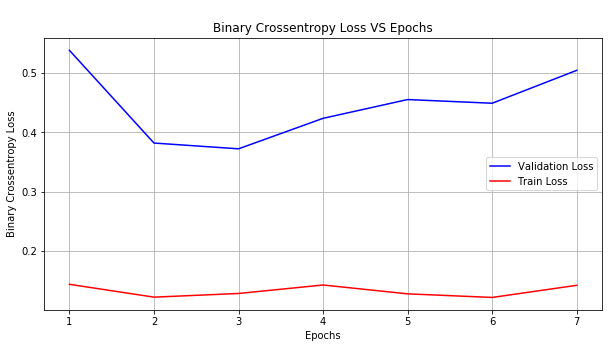

In [ ]:
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nBinary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()
x = list(range(1,8))
train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

## ** Note ** : We got train accuracy as '95.13' and validation accuracy as '91.101'

## Model II with optimal Hyperparameter [Addition of one more layer of LSTM]

In [ ]:
model_ii = Sequential()
# Configuring the parameters
model_ii.add(LSTM(27, input_shape=(timesteps, input_dim), return_sequences=True))
model_ii.add(LSTM(27))
# Adding a dropout layer
model_ii.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model_ii.add(Dense(n_classes, activation='sigmoid'))
model_ii.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 27)           3996      
_________________________________________________________________
lstm_3 (LSTM)                (None, 27)                5940      
_________________________________________________________________
dropout_2 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 168       
Total params: 10,104
Trainable params: 10,104
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model_ii.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
history = model_ii.fit(X_train,
          Y_train,
          batch_size=12,
          validation_data=(X_test, Y_test),
          epochs=7)

Train on 7352 samples, validate on 2947 samples
Epoch 1/7
7352/7352 [==============================] - 70s 9ms/step - loss: 0.2127 - acc: 0.9226 - val_loss: 0.5515 - val_acc: 0.8758
Epoch 2/7
7352/7352 [==============================] - 70s 9ms/step - loss: 0.2048 - acc: 0.9334 - val_loss: 0.6154 - val_acc: 0.8629
Epoch 3/7
7352/7352 [==============================] - 70s 10ms/step - loss: 0.1763 - acc: 0.9353 - val_loss: 0.5240 - val_acc: 0.8778
Epoch 4/7
7352/7352 [==============================] - 71s 10ms/step - loss: 0.1924 - acc: 0.9280 - val_loss: 0.5204 - val_acc: 0.8921
Epoch 5/7
7352/7352 [==============================] - 71s 10ms/step - loss: 0.1790 - acc: 0.9433 - val_loss: 0.4137 - val_acc: 0.8894
Epoch 6/7
7352/7352 [==============================] - 72s 10ms/step - loss: 0.1591 - acc: 0.9433 - val_loss: 0.4895 - val_acc: 0.8853
Epoch 7/7
7352/7352 [==============================] - 72s 10ms/step - loss: 0.1668 - acc: 0.9419 - val_loss: 0.4636 - val_acc: 0.8846


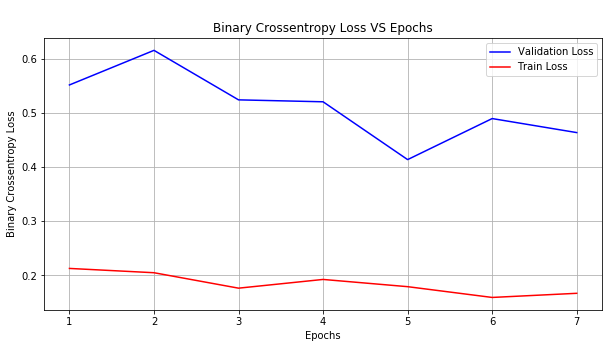

In [ ]:

train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("S.NO",[1,2])
x.add_column("#f Epochs",[7,7])
x.add_column("Model Description",["Model with 1 layer of LSTM + Dropout = 0.3 + #F LSTM = 27"
,"Model with 2 layer of LSTM + Dropout = 0.3 + #F LSTM = 27"])
x.add_column("Train Accuracy",["95.13","94.19"])
x.add_column("Validation Accuracy",["91.101" ,"88.46" ])
print(x)

+------+-----------+-----------------------------------------------------------+----------------+---------------------+
| S.NO | #f Epochs |                     Model Description                     | Train Accuracy | Validation Accuracy |
+------+-----------+-----------------------------------------------------------+----------------+---------------------+
|  1   |     7     | Model with 1 layer of LSTM + Dropout = 0.3 + #F LSTM = 27 |     95.13      |        91.101       |
|  2   |     7     | Model with 2 layer of LSTM + Dropout = 0.3 + #F LSTM = 27 |     94.19      |        88.46        |
+------+-----------+-----------------------------------------------------------+----------------+---------------------+


In [ ]:
# #  !pip install hyperas
# # !pip install networkx==1.11
# from __future__ import print_function
# from hyperopt import Trials, STATUS_OK, tpe
# from keras.layers.core import Dense, Dropout, Activation
# from keras.models import Sequential
# from keras.utils import np_utils
# from hyperas import optim
# from hyperas.distributions import choice, uniform


# def create_model(x_train, y_train, x_test, y_test):
#     #############################################################
#     #############################################################
#     model = Sequential()
#     # Configuring the parameters
# #     n_hidden = [ i for i in range(2, 50)]
#     model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
#     # Adding a dropout layer
#     model.add(Dropout({{uniform(0, 1)}}))
#     # Adding a dense output layer with sigmoid activation
#     model.add(Dense(n_classes, activation='sigmoid'))
#     ##############################################################
#     ##############################################################
    
    
# #     model = Sequential()
# #     model.add(Dense(512, input_shape=(784,)))
# #     model.add(Activation('relu'))
# #     model.add(Dropout({{uniform(0, 1)}}))
# #     model.add(Dense({{choice([256, 512, 1024])}}))
# #     model.add(Activation({{choice(['relu', 'sigmoid'])}}))
# #     model.add(Dropout({{uniform(0, 1)}}))

# #     # If we choose 'four', add an additional fourth layer
# #     if {{choice(['three', 'four'])}} == 'four':
# #         model.add(Dense(100))

# #         # We can also choose between complete sets of layers

# #         model.add({{choice([Dropout(0.5), Activation('linear')])}})
# #         model.add(Activation('relu'))

# #     model.add(Dense(10))
# #     model.add(Activation('softmax'))

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
#                   optimizer='adam')

#     result = model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               verbose=2,
#               validation_split=0.1)
#     #get the highest validation accuracy of the training epochs
#     validation_acc = np.amax(result.history['val_acc']) 
#     print('Best validation acc of epoch:', validation_acc)
#     return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}


# if __name__ == '__main__':
#     best_run, best_model = optim.minimize(model=create_model,
#                                           data=load_data(),
#                                           algo=tpe.suggest,
#                                           max_evals=5,
#                                           trials=Trials(), 
#                                          notebook_name='/drive/My Drive/Colab Notebooks/HAR_LSTM')
#     X_train, Y_train, X_test, Y_test = load_data()
#     print("Evalutation of best performing model:")
#     print(best_model.evaluate(X_test, Y_test))
#     print("Best performing model chosen hyper-parameters:")
#     print(best_run)
# # # Initiliazing the sequential model
# # model = Sequential()
# # # Configuring the parameters
# # model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# # # Adding a dropout layer
# # model.add(Dropout(0.5))
# # # Adding a dense output layer with sigmoid activation
# # model.add(Dense(n_classes, activation='sigmoid'))
# # model.summary()